# Školski rad: primjena strojnog učenja

Ovaj rad se bazira na primjeni strojnoga učenja kako bi se predvidio žanr pjesme ukoliko se pruže modelu odgovarajuće značajke pjesme 


**Definicja problema:** S obzirom na dane značajke i parametre pjesme, potrebno je klasificirati pjesmu unutar određenom žanra

**Podatci:** Podatci svih audio značajki pojedine pjesme prikupljeni su pomoću Spotify API-a, a cijeli dokument s podatcima može se pronaći na https://www.kaggle.com/mrmorj/dataset-of-songs-in-spotify


**Definiranje značajki pjesme**
* **Plesnost**: opisuje koliko je pjesma prikladna za ples na temelju kombinacije različitih glazbenih elemenata kao što su tempo, stabilnost ritma, snaga takta, a vrijednost 0.0 označuje pjesmu koja je najmanje prikladna za ples dok 1.0 označava najprikladniju pjesmu za ples
* **Akustičnost**: označava koliko je pjesma akustična od 0.0 do 1.0
* **Energija**: mjera koja predstavlja koliko je određena pjesma intezivna i aktivna. Energične pjesme uobičajeno se percipiraju kao brza, glasna i bučna glazba te se u okviru ove mjere ona označava 1.0 dok se spora i tiha glazba označava s 0.0
* **Intstumentalnost**: Predviđa vjerojatnost da pjesma sadrži vokale te što je bliže 1.0, to je veća vjerojatnost da pjesma ne sadrži vokale
* **Živost**: Predviđa vjerojatnost pristunosti publike na snimci, odnosno predstavlja vjerojatnost da je pjesma izvedena uživo
* **Glasnoća**: Ukupna glasnoća koja je zapisana u decibelima (dB), a njezina vrijednost tipično se kreće između -60 i 0 dB te predstavlja prosječnu vrijednost glasnoće kroz cijeli audio zapis pjesme
* **Govornost**: predstavlja prisutnost izgovorenih riječi unutar pjesme, odnosno što je audio zapis sličniji govoru, to je vrijednost ove značajke bliža 1.0
* **Tempo**: Ukupni tempo pjesme mjeren u otkucajima (dobima) po minuti (BPM)
* **Valenca**: Mjera od 0.0 do 1.0 koja označava koliko je pjesma sadrži pozitivnu (sreća, veselje, euforičnost) ili negativnu (tuga, potištenje, bijes) tematiku
* **Ključ**: Notni ključ u kojemu se pjesma nalazi koja je označena brojem od 1 do 12 (npr. 0 = C, 1 = C♯/D♭, 2 = D...)
* **Mod**: Označava tonski rod (dur ili mol) pjesme


**Žanrovi pjesama (unutar podataka)**: Trap, Techno, Techhouse, Trance, Psytrance, Dark Trap, DnB (drums and bass), Hardstyle, Underground Rap, Trap Metal, Emo, Rap, RnB, Pop and Hiphop

## Pripremanje alata za analizu podataka, manipulaciju podataka i modela

**Pandas** - preuzimanje i unošenje matrica i podataka (https://pandas.pydata.org/docs/)<br>
**Numpy** - računske operacije na matricama i podatcima (https://numpy.org/doc/stable/)<br>
**Matplotlib** - prikazivanje podataka (https://matplotlib.org/)<br>
**Seaborn** - također prikazivanje podataka, baziran na matplotlibu (https://seaborn.pydata.org/)<br>
**Scikit** - primijena strojnog učenja i stvaranja modela (https://scikit-learn.org/)<br>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# SK Learn modeli
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Evaluacija modela
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve, accuracy_score

# Vizualizacija modela
from sklearn.tree import export_graphviz
from sklearn import tree
import os

## Učitavanje podataka

In [2]:
df = pd.read_csv("genres_v2.csv", low_memory=False)
df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,id,uri,track_href,analysis_url,duration_ms,time_signature,genre,song_name,Unnamed: 0,title
0,0.831,0.814,2,-7.364,1,0.4200,0.059800,0.013400,0.0556,0.3890,...,2Vc6NJ9PW9gD9q343XFRKx,spotify:track:2Vc6NJ9PW9gD9q343XFRKx,https://api.spotify.com/v1/tracks/2Vc6NJ9PW9gD...,https://api.spotify.com/v1/audio-analysis/2Vc6...,124539,4,Dark Trap,Mercury: Retrograde,NaN,NaN
1,0.719,0.493,8,-7.230,1,0.0794,0.401000,0.000000,0.1180,0.1240,...,7pgJBLVz5VmnL7uGHmRj6p,spotify:track:7pgJBLVz5VmnL7uGHmRj6p,https://api.spotify.com/v1/tracks/7pgJBLVz5Vmn...,https://api.spotify.com/v1/audio-analysis/7pgJ...,224427,4,Dark Trap,Pathology,NaN,NaN
2,0.850,0.893,5,-4.783,1,0.0623,0.013800,0.000004,0.3720,0.0391,...,0vSWgAlfpye0WCGeNmuNhy,spotify:track:0vSWgAlfpye0WCGeNmuNhy,https://api.spotify.com/v1/tracks/0vSWgAlfpye0...,https://api.spotify.com/v1/audio-analysis/0vSW...,98821,4,Dark Trap,Symbiote,NaN,NaN
3,0.476,0.781,0,-4.710,1,0.1030,0.023700,0.000000,0.1140,0.1750,...,0VSXnJqQkwuH2ei1nOQ1nu,spotify:track:0VSXnJqQkwuH2ei1nOQ1nu,https://api.spotify.com/v1/tracks/0VSXnJqQkwuH...,https://api.spotify.com/v1/audio-analysis/0VSX...,123661,3,Dark Trap,ProductOfDrugs (Prod. The Virus and Antidote),NaN,NaN
4,0.798,0.624,2,-7.668,1,0.2930,0.217000,0.000000,0.1660,0.5910,...,4jCeguq9rMTlbMmPHuO7S3,spotify:track:4jCeguq9rMTlbMmPHuO7S3,https://api.spotify.com/v1/tracks/4jCeguq9rMTl...,https://api.spotify.com/v1/audio-analysis/4jCe...,123298,4,Dark Trap,Venom,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42300,0.528,0.693,4,-5.148,1,0.0304,0.031500,0.000345,0.1210,0.3940,...,46bXU7Sgj7104ZoXxzz9tM,spotify:track:46bXU7Sgj7104ZoXxzz9tM,https://api.spotify.com/v1/tracks/46bXU7Sgj710...,https://api.spotify.com/v1/audio-analysis/46bX...,269208,4,hardstyle,NaN,20995.0,Euphoric Hardstyle
42301,0.517,0.768,0,-7.922,0,0.0479,0.022500,0.000018,0.2050,0.3830,...,0he2ViGMUO3ajKTxLOfWVT,spotify:track:0he2ViGMUO3ajKTxLOfWVT,https://api.spotify.com/v1/tracks/0he2ViGMUO3a...,https://api.spotify.com/v1/audio-analysis/0he2...,210112,4,hardstyle,NaN,20996.0,Greatest Hardstyle Playlist
42302,0.361,0.821,8,-3.102,1,0.0505,0.026000,0.000242,0.3850,0.1240,...,72DAt9Lbpy9EUS29OzQLob,spotify:track:72DAt9Lbpy9EUS29OzQLob,https://api.spotify.com/v1/tracks/72DAt9Lbpy9E...,https://api.spotify.com/v1/audio-analysis/72DA...,234823,4,hardstyle,NaN,20997.0,Best of Hardstyle 2020
42303,0.477,0.921,6,-4.777,0,0.0392,0.000551,0.029600,0.0575,0.4880,...,6HXgExFVuE1c3cq9QjFCcU,spotify:track:6HXgExFVuE1c3cq9QjFCcU,https://api.spotify.com/v1/tracks/6HXgExFVuE1c...,https://api.spotify.com/v1/audio-analysis/6HXg...,323200,4,hardstyle,NaN,20998.0,Euphoric Hardstyle


## Istraživačka analiza i manipluacija podataka

Cilj ovoga odjeljka je istražiti podatke i učiniti potrebne postupke kako bi podatci bili pripremljeni za model <br>
Određeni postupak koji će se u ovom radu koristiti:

* Postoje li parametri i značajke koje se mogu dodati, promijeniti ili ukloniti kako bi model mogao biti precizniji
* Promijeniti nazive podataka (prevesti s engleskog jezika na hrvatski kako bi se podudarali s prijašnje navedenim značajkama)
* Utvrditi postoje li podatci koji nedostaju te ukoliko nedostaju ih je potrebno ukloniti ili nadopuniti
* Koji svi tipovi podataka se nalaze unutar skupa podataka (numerički, tekstualni...) te ih sve pretvoriti u numeričke vrijednosti
* Dodatno istražiti podatke i njihove informacije

### Podatci koji nedostaju

Prvi korak će biti pronalaženje podataka koji nedostaju i primijeniti adekvatan postupak nad njima

In [3]:
df.isna().sum()

danceability            0
energy                  0
key                     0
loudness                0
mode                    0
speechiness             0
acousticness            0
instrumentalness        0
liveness                0
valence                 0
tempo                   0
type                    0
id                      0
uri                     0
track_href              0
analysis_url            0
duration_ms             0
time_signature          0
genre                   0
song_name           20786
Unnamed: 0          21525
title               21525
dtype: int64

Pošto podatci koji nedostaju (naziv pjesme, nepoznati parametar "Unnamed: 0" i naslov) neće biti potrebni u ovome radu iz razloga što je cilj samo utvrđivanje žanra pjesme, mogu se ukloniti u potpunosti

In [4]:
drop_list = ["song_name", "Unnamed: 0", "title"]

df = df.drop(columns=drop_list, axis=1)

### Uklanjanje nepotrebnih podataka

U prijašnjem odjeljku su se već uklonila nepotrebna nekolicina podataka, stoga je sljedeći korak ukloniti ostale nepotrebne podatke, odnosno one parametre koji nisu definirani u uvodnom odjeljku ili ne predstavljaju žanr određene pjesme

In [5]:
drop_list_2 = ["type", "id", "uri", "track_href", "analysis_url",
               "duration_ms", "time_signature"]

df = df.drop(columns=drop_list_2, axis=1)

### Prijevod naziva

Nazivi stupaca koji se trenutačno nalaze unutar baze podataka se podudaraju s prijašnje navedenim parametrima te iz tog razloga je idealno vrijeme za promjenu naziva podataka (s engleskog jezika na hrvatski)

In [6]:
df = df.rename(columns={
    "danceability": "Plesnost",
    "energy": "Energija",
    "key": "Ključ",
    "loudness": "Glasnoća",
    "mode": "Mod",
    "speechiness": "Govornost",
    "acousticness": "Akustičnost",
    "instrumentalness": "Intstumentalnost",
    "liveness": "Živost",
    "valence": "Valenca",
    "tempo": "Tempo",
    "genre": "Žanr"
})

df

,Plesnost,Energija,Ključ,Glasnoća,Mod,Govornost,Akustičnost,Intstumentalnost,Živost,Valenca,Tempo,Žanr
0,0.831,0.814,2,-7.364,1,0.4200,0.059800,0.013400,0.0556,0.3890,156.985,Dark Trap
1,0.719,0.493,8,-7.230,1,0.0794,0.401000,0.000000,0.1180,0.1240,115.080,Dark Trap
2,0.850,0.893,5,-4.783,1,0.0623,0.013800,0.000004,0.3720,0.0391,218.050,Dark Trap
3,0.476,0.781,0,-4.710,1,0.1030,0.023700,0.000000,0.1140,0.1750,186.948,Dark Trap
4,0.798,0.624,2,-7.668,1,0.2930,0.217000,0.000000,0.1660,0.5910,147.988,Dark Trap
...,...,...,...,...,...,...,...,...,...,...,...,...
42300,0.528,0.693,4,-5.148,1,0.0304,0.031500,0.000345,0.1210,0.3940,150.013,hardstyle
42301,0.517,0.768,0,-7.922,0,0.0479,0.022500,0.000018,0.2050,0.3830,149.928,hardstyle
42302,0.361,0.821,8,-3.102,1,0.0505,0.026000,0.000242,0.3850,0.1240,154.935,hardstyle
42303,0.477,0.921,6,-4.777,0,0.0392,0.000551,0.029600,0.0575,0.4880,150.042,hardstyle


### Pretvaranje svih podataka u numeričke vrijednosti

Iz razloga što svaki model strojnog učenja može raditi samo s numeričkim vrijednostima, potrebno je pronaći sve tipove vrijednosti unutar baze podataka i promijeniti ih ukoliko je to potrebno

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42305 entries, 0 to 42304
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Plesnost          42305 non-null  float64
 1   Energija          42305 non-null  float64
 2   Ključ             42305 non-null  int64  
 3   Glasnoća          42305 non-null  float64
 4   Mod               42305 non-null  int64  
 5   Govornost         42305 non-null  float64
 6   Akustičnost       42305 non-null  float64
 7   Intstumentalnost  42305 non-null  float64
 8   Živost            42305 non-null  float64
 9   Valenca           42305 non-null  float64
 10  Tempo             42305 non-null  float64
 11  Žanr              42305 non-null  object 
dtypes: float64(9), int64(2), object(1)
memory usage: 3.7+ MB


In [8]:
df["Žanr"] = df.Žanr.astype("category")

### Dodatno istraživanje podataka

Baza podataka je spremna za model strojnog učenja, no potrebno je dodatno istražiti bazu podataka kako bi se postiglo bolje razumjevanja podataka s kojima će se nastaviti daljnji rad

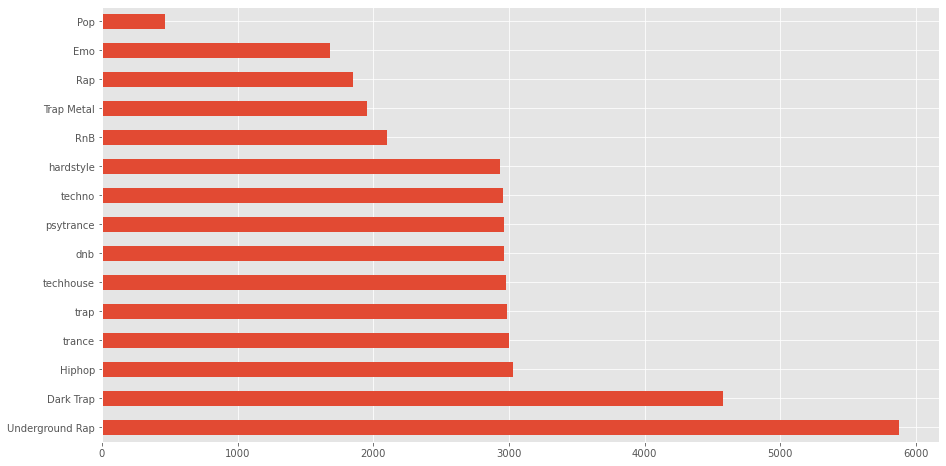

In [9]:
plt.style.use('ggplot') # Uređivanje izgleda grafova
df["Žanr"].value_counts().plot(kind="barh", figsize=(15,8));

Iz sljedećeg grafa je vidljivo kako baza podataka sadrži izrazito malu količinu uzorka pop glazbe i velike količine uzorka Dark Trap i Underground Rap glazbe zbog čega vrijedi naslutiti kako će model teže prepoznati pop glazbu.

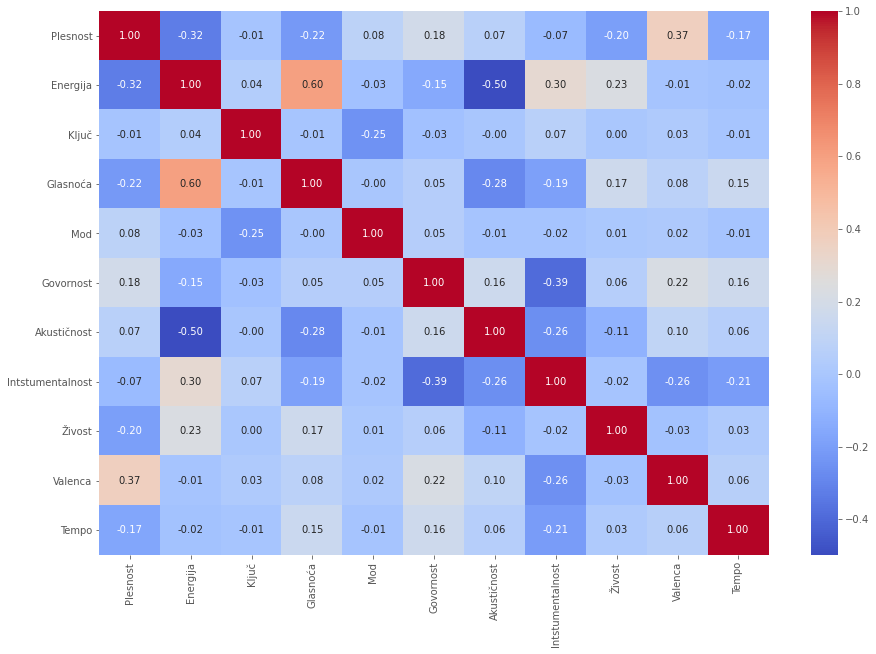

In [10]:
korelacije = df.corr()

fix, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(korelacije,
                 annot=True,
                 fmt=".2f",
                 cmap="coolwarm")

Iako koeficijent korelacije ne otkriva kako će pojedini parametri utjecati na žanr pjesme, moguće je odrediti njihove određene međudosbne veze. Najveći koeficijent korelacije među parmetrima je između glasnoće i energije glazbe (+0.60) što je često slučaj u pjesmama jer se glasnije pjesme asociraju s visokom energijom dok akustične pjesme su češće i pjesme s manje energije zbog čega je njihov koeficijent korelacije izrazito nizak (-0.50). Pjesme uz koje se može lagano plesati također imaju tenedciju biti sretnije i pozitivnije tematike te iz tog razloga je njihov koefcijent korelacije +0.37

## Modeliranje

Nakon istraživanja podataka, njihovog manipuliranja i modificiranja, spremni su za stvaranje modela strojnog učenja. U ovome radu napraviti će se 2 različita modela strojnog učenja te će se dodatno poboljšati modeli koji će imati najbolje rezultate.
Modeli koji će se koristiti:

Random forest classifier (Stablo odlučivanja) - kodira i u svoju strukturu ugrađuje skup pravila tipa ako, onda
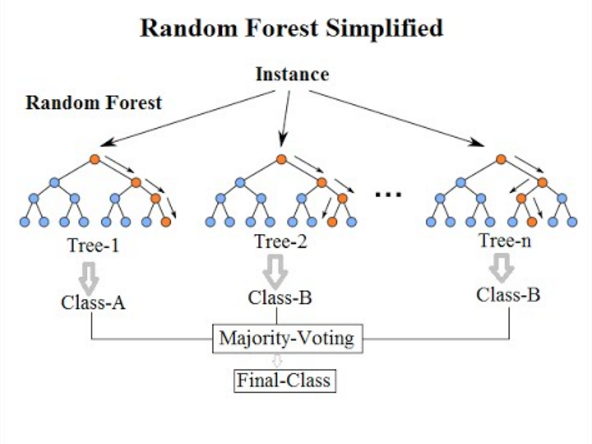
K nearest neighbor (algoritam najbližih susjeda) - određivanje klase parametra pomoću najvećeg broja pristunih podataka određene klase unutar radijusa (r) kruga
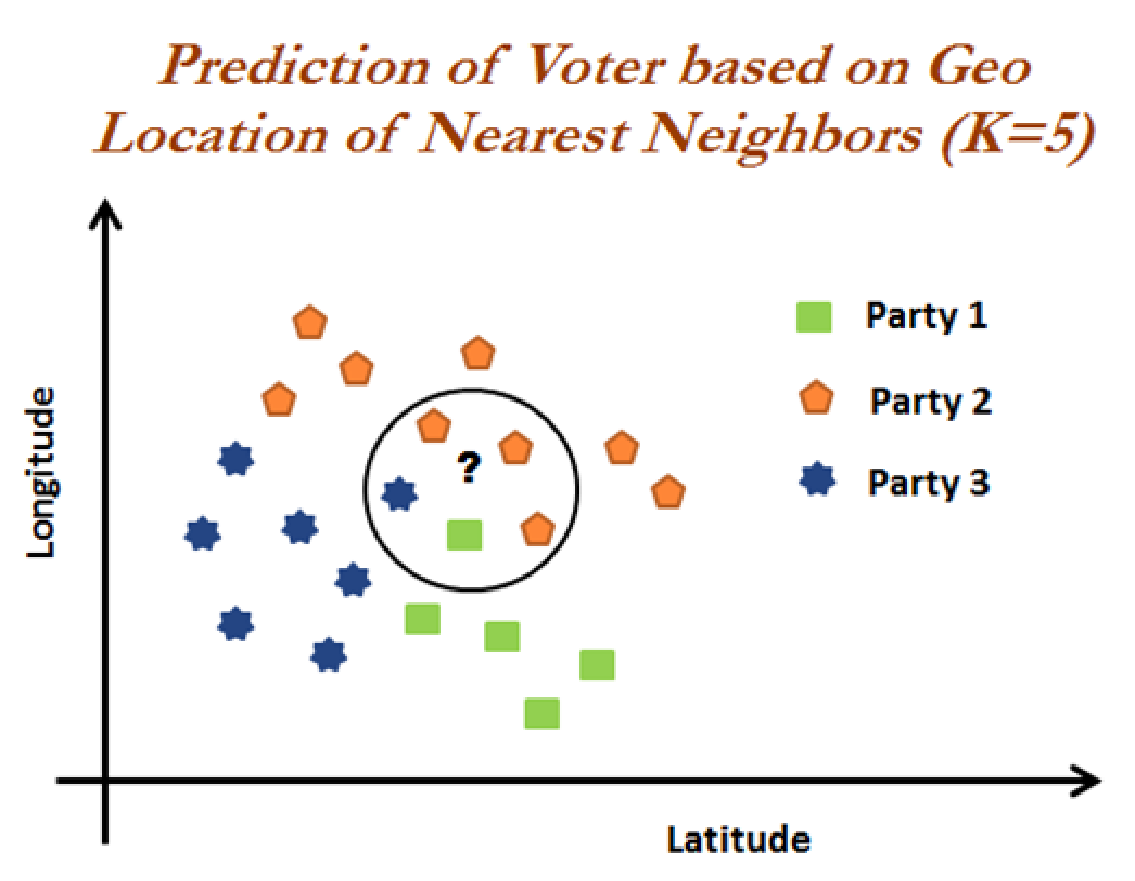

<br><br><br>
Također je potrebno odrediti metriku po kojoj će se evaluirati uspješnost modela:
* Matrica konfuzije (confusion matrix)
* Točnost
* Preciznost (recall/precision)
* F1 (F1 score)

In [11]:
df.head()

,Plesnost,Energija,Ključ,Glasnoća,Mod,Govornost,Akustičnost,Intstumentalnost,Živost,Valenca,Tempo,Žanr
0,0.831,0.814,2,-7.364,1,0.4200,0.0598,0.013400,0.0556,0.3890,156.985,Dark Trap
1,0.719,0.493,8,-7.230,1,0.0794,0.4010,0.000000,0.1180,0.1240,115.080,Dark Trap
2,0.850,0.893,5,-4.783,1,0.0623,0.0138,0.000004,0.3720,0.0391,218.050,Dark Trap
3,0.476,0.781,0,-4.710,1,0.1030,0.0237,0.000000,0.1140,0.1750,186.948,Dark Trap
4,0.798,0.624,2,-7.668,1,0.2930,0.2170,0.000000,0.1660,0.5910,147.988,Dark Trap


In [12]:
# Razdvajanje podataka u X i y
X = df.drop("Žanr", axis=1)
y = df["Žanr"]

# Postavljanje random seeda kako bi rezultati ostali isti
np.random.seed(10)

# Razdvajanje podataka u podatke za treniranje modela i testiranje modela
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2)

`X = df.drop("Žanr", axis=1)
y = df["Žanr"]`

Pomoću ovoga koda se podatci razdvajaju u X podatke koji sadrže sve parametre i značajke jednoga žanra, a oni će se koristiti kako bi model pronašao veze među podatcima. Y podatci sadrže žanr pjesme kojega će model trebat prepoznati kada se bude testirao

`np.random.seed(10)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2)`
                                                    
Sljedeći korak je razdvajanje X i Y podataka u podatke za treniranje modela i podatke za testiranje modela što se postiže pomoću `train_test_split` koji nasumično razdvaja X i Y podatke na podatke za treniranje modela koji će sadržavati 80% (`test_size=0.2`) baze podataka, a pomoću njih će model uočiti sličnosti među podatcima i njihove međusobne veze. Ostalih 20% podataka se koristi za testiranje modela te će se na njima model evaluirati tako što će imati pristup samo X podatcima te će predvidjeti kojem žanru pripada pjesma, a tek nakon toga će se koristiti Y podatci kako bi se evaluirala točnost modela.


In [13]:
# Postavljanje modela
modeli = {
    "Stablo odlučivanja": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVC": SVC()
}

# Funkcija koja služi za treniranje i prvobitno evaluiranje modela
def fit_score(modeli, X_train, X_test, y_train, y_test):
    """
    Treniranje i prvobitno evaluiranje modela
    modeli: rječnik koji sadrži SciKit Learn modele 
    """
    
    # Random seed
    np.random.seed(10)
    
    # Rječnik koji će sadržavati točnost svakoga modela
    točnost_modela = {}
    
    for ime_modela, model in modeli.items():
        
        # Treniranje modela
        model.fit(X_train, y_train)
        
        # Evaluiranje modela i dodavanje njegove točnosti u rječnik
        točnost_modela[ime_modela] = model.score(X_test, y_test)
        
    return točnost_modela

`modeli = {
    "Stablo odlučivanja": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVC": SVC()
}`
    
Postavlja se rječnik koji sadrži imena modela kako bi se lakše prikazala njihova točnost, a uz njih se nalaze odgovarajući modeli koji na kojima će se trenirat i testirati X i Y podatci.

`np.random.seed(10)`

Prvi korak je ponvno postavljanje random seeda koji će omogućiti rezultatima da ne budu nasumični (npr. kada bi se nasumično birala 3 broja između 1 i 100, ukoliko je postavljen random seed, iako će brojevi biti nasumično odabrani, svaki put kada se pokrene ovaj blok koda će brojke ostati iste, a u suprotnom bi svako sljedeće pokretanje bile različite)

`model.fit(X_train, y_train)`

Zatim slijedi treniranje modela gdje pojedini modeli uočavaju sličnosti i veze među podatcima pomoću svojih jedinstvenih algoritama

`točnost_modela[ime_modela] = model.score(X_test, y_test)`

Na kraju se točnost modela dodaje u rječnik pod samim imenom modela kako bi se lagano mogli prikazati njihovi rezultati

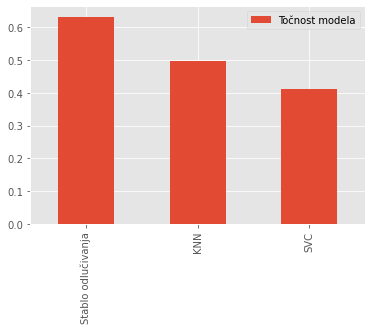

In [14]:
rezultati = fit_score(modeli, X_train, X_test, y_train, y_test)

tablica_rezultata = pd.DataFrame(rezultati, index=["Točnost modela"])
tablica_rezultata.T.plot.bar();

In [15]:
rezultati

{'Stablo odlučivanja': 0.6318402080132373,
 'KNN': 0.49793168656187214,
 'SVC': 0.41094433282117954}

Iz rezultata je vidljivo kako je stablo odlučivanja najučinkovitije za ovaj problem te iz tog razloga je najbolje unaprijediti prvo taj model 

In [16]:
# Random seed 
np.random.seed(10)

model = RandomForestClassifier()

model.fit(X_train, y_train)

y_preds = model.predict(X_test)

## Evaluacija modela

Modeli će se evaluirati pomoću:

* **Točnosti**: govori koliki je udio rezultata (žanrova) model točno predvidio (fromula: *točno predviđeni žanrovi pjesama / ukupni broj pjesama*)
* **Opoziv (recall)**: govori koliko udio predviđenih vrijednosti je točno predviđen (fromula: *zbroj točno predviđenih vrijednosti svih klasa (žanrova) / zbroj svih istinitih vrijednosti kroz sve klase (žanrove)*)
* **Preciznost (precision)**: govori koliki udio istnitih vrijednosti (žanrova) je točno predviđen (formula: *zbroj točno predviđenih vrijednosti svih klasa (žanrova) / zbroj točno i netočno predviđenih vrijednosti kroz sve klase (žanrove)*) 
* **F1-rezultat**: srednja vrijednost između opoziva i preciznosti 
* **Matrica vrijednosti (confusion matrix)**: matrica koja sadrži vrijednosti koje je model predvidio i istinite vrijednosti kako bi se moglo evaluirati gdje model postiže točne rezultate i gdje griješi

*predviđena vrijednost* - žanr kojega je model predivdio za određenu pjesmu<br>
*istnita vrijednost* - žanr kojem određena pjesma zapravo pripada

In [17]:
def evaluacija(y_vrijednosti, y_pred):
    
    """
    Funkcija kojom će se evaluirati točnost, opoziv, preciznost i f1 modela
    """
    
    točnost = accuracy_score(y_vrijednosti, y_pred)
    opoziv = recall_score(y_vrijednosti, y_pred, average='macro')
    preciznost = precision_score(y_vrijednosti, y_pred, average='weighted')
    f1 = f1_score(y_vrijednosti, y_pred, average='weighted')
    
    vrijednosti={
        "točnost": round(točnost, 2),
        "opoziv": round(opoziv, 2),
        "preciznost": round(preciznost, 2),
        "f1-rezultat": round(f1, 2)
    }
    
    print(f"Točnost modela: {točnost*100:.2f}%")
    print(f"Opoziv modela: {opoziv*100:.2f}%")
    print(f"Preciznost modela: {preciznost*100:.2f}%")
    print(f"F1-rezultat modela: {f1*100:.2f}%")
    
    return vrijednosti

def prikaz_evaluacije(**kwargs):
    
    """
    Funkcija kojom će se prikazati sve metrike pomoću grafa kako bi se njihovi
    rezultati bolje vizualizirali
    """
    
    lista = []
    
    for k, v in kwargs.items():
        k = pd.DataFrame(v, index=[k])
        lista.append(k)
        
    tablica = pd.concat(lista)
    tablica.T.plot.bar(figsize=(10, 6));

Stvorena je funkcija `evaluacija(y_vrijednosti, y_pred)` kako bi se automatizirao proces evaluiranja svakoga modela što znači da pri evaluaciji pojedinačnoga modela nije potrebno pisati kod koji se nalazi unutar ove funkcije, nego je potrebno samo pozvati ovu funkciju i pružiti joj potrebne varijable, `y_vrijednosti` (varijabla koja sadrži listu istinitih vrijednosti žanrova) i `y_pred` (varijabla koja sadrži listu predviđenih vrijednosti žanrova pojedinačnog modela). Ove varijable su potrebne iz razloga što Scikit Learn zahtijeva listu istinitih i predviđenih vrijednosti kako bi evaluirao model prema potrebnim metrikama.

`točnost = accuracy_score(y_vrijednosti, y_pred)
 opoziv = recall_score(y_vrijednosti, y_pred, average='weighted')
 preciznost = precision_score(y_vrijednosti, y_pred, average='weighted')
 f1 = f1_score(y_vrijednosti, y_pred, average='weighted')`

Svaka od prijašnje navedenih metrika se izračunava pomoću SciKit Learn-ovih unaprijed izgrađenih funkcija, a `average='weighted'` u funkcijama gdje se računaju preciznost i F1-rezultat znači da uzima u obzir neravnotežu među podatcima te ne mjeri vrijednosti metrika prema količini klasa (u ovom slučaju žanrova) nego prema količini podataka, no ovaj način evaluiranja može dovesti do F1-rezultata koji nije nužno aritmetička sredina vrijednosti preciznosti i opoziva. Bez obzira na to što F1-rezultat neće onakva kako je prijašnje definirana, ovaj način evaluacije je najbolji za ovaj zadani problem jer u bazi podataka postoji velika razlika među količinama podataka po žanru. 

Za razliku od preciznosti i F1-rezultata, opoziv će se mjeriti pomoću `average='macro'` iz razloga što se točnost modela već mjeri pomoću opoziva čiji je `average='weighted'` te će također dati više informacija o rezultatu modela s obzirom na količinu klasa.

Kako bi se bolje objasnila razlika između macro i weighted avarage-a može se uzeti primjer klasifikacije rijetke bolesti: U ovome primjeru uzima se hipotetski slučaj u kojemu postoji rijetka bolest kojom je zaražena mala količina ljudi te iz tog razloga se pravi model koji će probati klasificirati osobe zaražene ovom bolešću. Modelu je dano 10 000 primjeraka osoba te on svaku osobu klasificira kao zdravu osobu, odnosno osobu koja nije zaražena ovom bolesti, no u stvarnosti jedna osoba od tih 10 000 je zaražena njome. Kada bi evaluirali opoziv i preciznost ovoga modela prema `average='weighted'`, oboje bi bili 99.99% jer je model točno predvidio 9999 osoba. U slučaju kada bi opoziv i preciznost ovoga modela ovaj puta evaluirali prema `average='macro'`, oni bi bili ≈50% jer jedna klasa (zaraženih osoba) od dvije klase nije točno klasificirana. Stoga oba načina evaluiranja su točna, a koji će se način koristiti ovisi o problemu i krajnjem rezultatu kojega se pokušava postići. U ovome slučaju cilj je točno klasificirati žanr pjesme te se zbog toga koristi `average='weighted'` kako bi se dobile metrike s obzirom na sveukupnu količinu pjesama.

Ova funkcija također pohranjuje rječnik koji sadrži informacije o iznosu svake metrike te će se on pohraniti u varijablu `vrijednosti` koja će se koristiti za sljedeću funkciju, `prikaz_evaluacije(**kwargs)`, koja pomoću varijable `vrijednosti` pravi graf kako bi se i vizualno prikazale vrijednosti svake metrike. `**kwargs` znači da ova funkcija može prihvatiti neodređen broj `vrijednosti` te će se na taj način također moći usporediti različite verzije modela.

In [18]:
y_pred = model.predict(X_test)
vrijednosti = evaluacija(y_test, y_pred)

Točnost modela: 63.18%
Opoziv modela: 59.17%
Preciznost modela: 62.42%
F1-rezultat modela: 62.38%


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Žanrovi,Dark Trap,Emo,Hiphop,Pop,Rap,RnB,Trap Metal,Underground Rap,dnb,hardstyle,psytrance,techhouse,techno,trance,trap


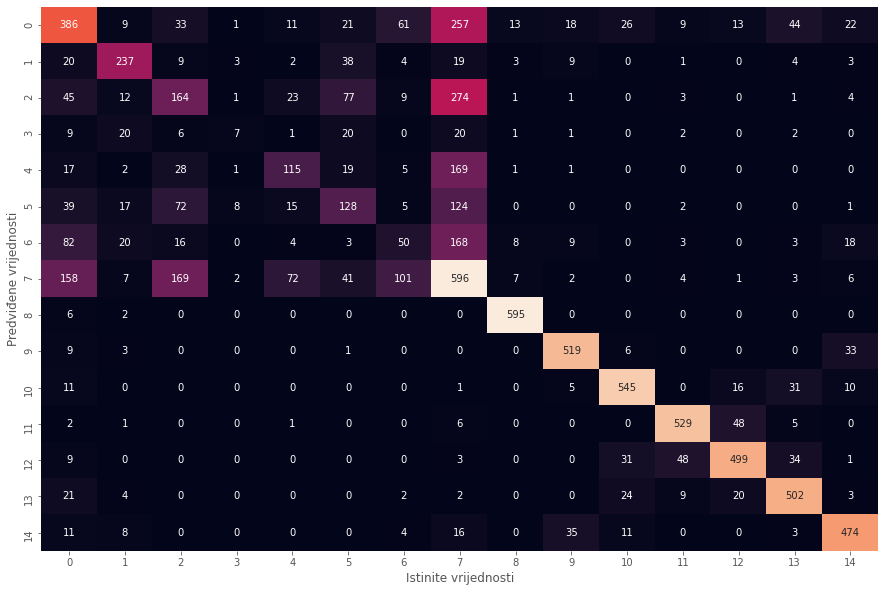

In [19]:
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                 annot=True,
                 fmt=".0f",
                 cbar=False)
plt.xlabel("Istinite vrijednosti")
plt.ylabel("Predviđene vrijednosti")

lista = pd.DataFrame(df.Žanr.dtype.categories, columns=["Žanrovi"])
lista.T

Pomoću matrice vrijednosti moguće je evaluirati gdje točno model ima poteškoće s točnim prevdviđanjem žanra pjesme. Prema matrici je vidljivo kako model najteže predviđa underground rep te ga klasificira među žanrove poput repa, hiphopa, dark trapa, rnb-a i trap metala. Ovo je pretežito iz razloga što underground rep se ne razlikuje od običnoga repa prema glazbenim karakteristikama nego po toma što reperi unutar ovoga žarna odbijaju potpisati s diskografskim kućama jer smatraju kako će one prezueti kontrolu nad njihovom glazbom.

Također je vidljivo kako model najbolje prepoznaje elektroničku glazbu kao što su dnb (drum & bass), hardstyle, psytrance, techhouse, techno, trance i trap što potiče iz činjenice da u pjesmama ovoga žanra gotov nema teksta ili u potpunosti nije prisutan te su ove pjesme u potpunosti karakterizirana prema njihovoj brzini, ritmu, tempu...

Kategorija pop glazbe gotovo nema uzoraka zbog čega model nije precizan pri njenome klasificiranju.

# Poboljšavanje modela

Model stabla odlučivanja je imao najbolji rezultat među svim modelima zbog čega će se on uzeti kao glavni model za poboljšavanje. Jedan od načina kojima se može poboljšati model je pomoću podešavanja raznih hiperparametara modela kako bi se bolje prilagodio zadanome problemu.

Hiperparametri su parametri koje svaki model posjeduje te se oni mogu manualno modificirati kako bi se poboljšala efikasnost modela, a oni se mogu podesiti na način da se SciKit Learn model stabla odlučivanja u zagrada dodaju specifični hiperparametri koji trebaju biti uređeni. Pošto je izabran model stabla odlučivanja bit će podešeni njegovi sljedeći hiperparametri:

* **n_estimators**: Određuje broj stabala odlučivanja koji će biti napravljeni
* **max_depth**: Maksimalna razina do koje se grane stabla odlučivanja mogu rastavljati
* **max_features**: Najveći broj karakteristika koje model može uzeti u obzir kod jedne grane stabla odlučivanja
* **min_samples_leaf**: Najmanji broj uzoraka kojega mora posjedovati svaka grana kako bi grana postajala unutar stabla odlučivanja, odnsno svaka grana na posljednjoj razini stabla odlučivanja mora minimalno karakterizirati ovaj broj podataka unutar baze podataka
* **min_samples_split**: Najmanji broj uzoraka kojega mora posjedovati grana kako bi se razdvojila na 2 nove grane 

In [20]:
grid = {
    "n_estimators": [10, 50, 100, 200],
    "max_depth": [10, 25, 50, 75, 100, None],
    "max_features": ["auto", "sqrt"],
    "min_samples_leaf": [1, 2, 4],
    "min_samples_split": [2, 5, 10],
}

np.random.seed(10)

rs_clf = RandomForestClassifier(n_estimators=200,
                                min_samples_leaf=4,
                                min_samples_split=10,
                                max_features="sqrt",
                                max_depth=75)

rs_clf.fit(X_train, y_train);

Druga verzija modela će se ovaj puta napraviti pomoću SciKit Learn-ovog alata za pronalaženje hiperparametara "RandomizedSearchCV" (RSCV) koji istancira različite modele s različitim nasumičnim hiperparametrima koje izabire iz rječnika `gird` u kojemu se nalaze lise mogućih vrijednosti svakog hiperparametra koje RSCV nasumično izabire te evaluira svaki pojedini model i vraća hiperparametre modela koji je najbolje performirao. 

RSCV se također koristi specifičnim načinom evaluacije koji se naziva cross-validation (CV). Kada se modelu pruže podatci iz kojih će uočiti njihove međusobne veze, ti podatci su razdvojeni u podatke koji se služe za treniranje modela i sadrže 80% sveukupnih podataka, dok ostalih 20% podataka služi za evaluaciju modela. Problem kod ovoga načina evaluacie je to što su ti podatci nasumično razdvojeni te može doći do toga da model ima odličan rezultat kada ga evaluiramo, no kada bi opet nasumično odabrali različitih 80% za treniranje i 20% za testiranje, rezultati mogu ovaj puta biti iznimno loši. Zbog toga što postoji mogućnost da dođe do ovakve situacije koristi se CV način evaluacije gdje se model s istim hiperparametrima testira na 5 baza različito razdvojenih podataka koji se nikada ne ponavljaju te pošto se 20% podataka koristi za testiranje, ukoliko ih razdvojimo 5 puta na različite jedinstvene podatake, to će činiti 100% ukupnih podataka. Nakon toga se uzima aritmetička sredina svih 5 modela i njihovih metrika evaluacije te ovaj način evaluacije daje najtočniju moguću sliku preformansi modela.

`rs_clf = RandomizedSearchCV(estimator=model,
                             param_distributions=grid,
                             n_iter=20,
                             cv=5)`
                             
Ovaj kod se koristio za pronalaženje najboljih nasumičnih hiperparametara modela, no pošto ovaj proces pronalaženja troši veliku količinu vremena zato što se istancira 100 (`n_iter * cv`) različith vrsta modela, model RandomizedSearchCV se zamijenio s model stabla odlučivanja koji je posjedovao najbolje pronađene hiperparametre.

Najbolji hiperparametri za ovu verziju modela:
* n_estimators=200
* min_samples_leaf=4
* min_samples_split=10
* max_features="sqrt" ("sqrt" znači da je maksimalan broj karakteristika koje model može uzeti u obzir korijen iz broja karakteristika ili značajka baze podataka, u ovom slučaju baza sadrži 11 karakteristika √11 što je zaokruženo na 3)
* max_depth=75

Točnost modela: 64.05%
Opoziv modela: 59.01%
Preciznost modela: 63.54%
F1-rezultat modela: 62.76%


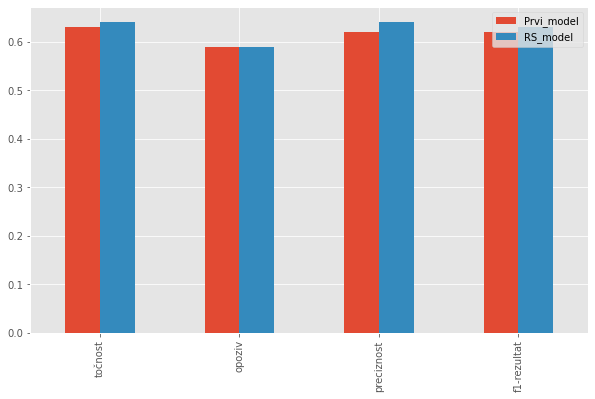

In [21]:
rs_pred = rs_clf.predict(X_test)
rs_vrijednosti = evaluacija(y_test, rs_pred)
prikaz_evaluacije(Prvi_model=vrijednosti, RS_model=rs_vrijednosti)

Vidljivo je kako RSCV model postiže bolje rezultate od polaznoga modela. Iako je model bolji, nije uvidna velika razlika među rezultatima modela, stoga je potrebno nastaviti nadograđivati model s ciljem da postigne točnost od 70%, što bi bio zadovoljavajuć rezultat s obzirom na zadaću koju model ima

In [22]:
grid = {
    "n_estimators": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "max_depth": [1, 2, 5, 10, 15, None],
    "max_features": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "min_samples_leaf": [1, 2, 4],
    "min_samples_split": [2, 4]
}

np.random.seed(10)

rs_clf_2 = RandomForestClassifier(n_estimators=10,
                                  min_samples_split=2,
                                  min_samples_leaf=2,
                                  max_features=4,
                                  max_depth=10)

rs_clf_2.fit(X_train, y_train);

Sljedeći model je također RSCV model, no ovaj puta se koriste manje brojke za hiperparametre kako bi se testirali rezultati koje će model postići ukoliko se smanji broj nasumičnih stabala i njihovih grana

U ovom slučaju su pronađeni sljedeći najbolji hiperparametri:
* n_estimators=10
* min_samples_split=2
* min_samples_leaf=2
* max_features=4
* max_depth=10

Točnost modela: 63.43%
Opoziv modela: 57.42%
Preciznost modela: 64.31%
F1-rezultat modela: 61.55%


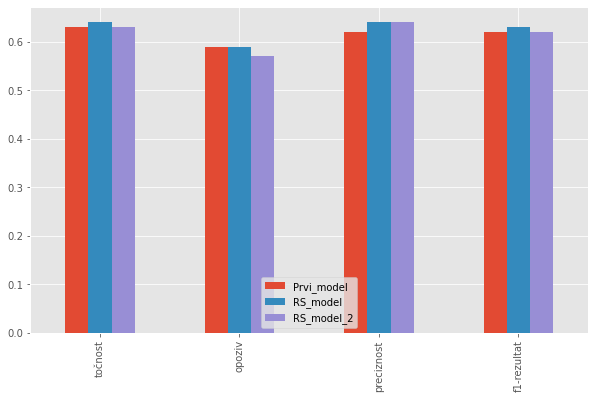

In [23]:
rs2_pred = rs_clf_2.predict(X_test)
rs2_vrijednosti = evaluacija(y_test, rs2_pred)
prikaz_evaluacije(Prvi_model=vrijednosti, RS_model=rs_vrijednosti, 
                  RS_model_2=rs2_vrijednosti)

Iz sljedećih rezultata je vidljivo kako ova verzija RSCV modela postiže najgore rezultate te je iz toga moguće zaključiti kako će model postići najbolje rezultate ukoliko model su iznosi njegovih parametara sličniji prvoj verziji RSCV modela. 

In [24]:
grid_search = {
    'n_estimators': [100, 200, 500],
    'max_depth': [50, 75, 100],
    'max_features': ['auto', 'sqrt'],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 4, 6]
}

np.random.seed(10)

# Prirpemanje Grid Search CV-a
gs_model = RandomForestClassifier(n_estimators=500,
                                  max_depth=100,
                                  max_features="auto",
                                  min_samples_leaf=2,
                                  min_samples_split=20)

# Treniranje modela
gs_model.fit(X_train, y_train);

Za istanciranje sljedećeg modela će se koristiti SciKit Learn-ova funkcije GridSearchCV (GSCV) koja je slična RSCV-u. Naime za razliku od RSCV-a koji nasumično odabire iznose svakog hiperparametra koje se nalaze u listi (lista su sve vrijednosti koje se nalaze u uglatim [ ] zagradama), GSCV prolazi kroz svaku vrijednost unutar liste te isprobava sve moguće kombinacije hiperparametara i evaluira ih na pomoću cross-validationa. 

Pošto je prva verzija RSCV modela imala najbolje rezultate, njezini hiperparametri će se uzeti kao referentna točka pri pravljenju iznosa liste hiperparametara za GSCV model. Zbog toga se pravi lista sljedećih mogućih hiperparametara:

`'n_estimators': [100, 200, 500],
 'max_depth': [50, 75, 100],
 'max_features': ['auto', 'sqrt'],
 'min_samples_split': [5, 10, 20],
 'min_samples_leaf': [2, 4, 6]`
 
Pošto proces pronalaženja hiperparametara ponvno zahtjeva puno vremena jer je potrebno istancirati 810, nakon što je GSCV pronašao najbolje hiperparametre, u kodu su zamijenjeni s modelom nasumičnog stabla koji posjeduje odgovarajuće pronađene hiperparametre koji iznose:

* n_estimators=500
* max_depth=100
* max_features="auto" ("auto" znači da model može sam odabrati koliki će broj karakteristika uzeti u obzir kod svake grane)
* min_samples_leaf=2
* min_samples_split=20

Točnost modela: 64.54%
Opoziv modela: 59.13%
Preciznost modela: 64.70%
F1-rezultat modela: 63.12%


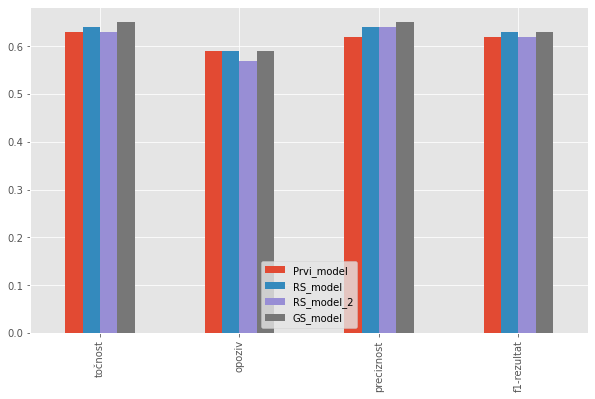

In [26]:
gs_pred = gs_model.predict(X_test)
gs_vrijednosti = evaluacija(y_test, gs_pred)
prikaz_evaluacije(Prvi_model=vrijednosti, RS_model=rs_vrijednosti, 
                  RS_model_2=rs2_vrijednosti, GS_model=gs_vrijednosti)

Ovaj model je postigao najbolje rezultate od svih verzija modela, no točnost modela i dalje nije postigla 70%, a razlike među točnostima modela promjenom hiperparametara su male. Iz toga razloga će se koristiti drugačiji pristup poboljšavanju modela na način da se umjesto mijenjanja modela **promijene podatci s kojima će model raditi**. Prvi korak je utvrditi važnosti značajki i karakteristika baze podataka

Značajka: Plesnost (11.57%)
Značajka: Energija (8.39%)
Značajka: Ključ (1.34%)
Značajka: Glasnoća (9.44%)
Značajka: Mod (0.49%)
Značajka: Govornost (6.80%)
Značajka: Akustičnost (6.97%)
Značajka: Intstumentalnost (13.51%)
Značajka: Živost (3.68%)
Značajka: Valenca (6.86%)
Značajka: Tempo (30.94%)


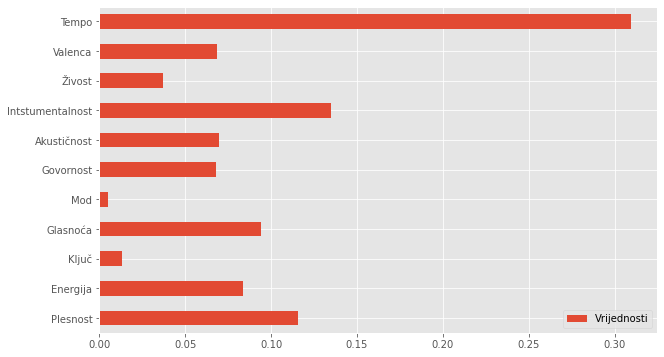

In [27]:
def prikazivanje_važnosti(model, df, X):
    važnost_značajki = model.feature_importances_
    for i, v in zip(df.columns, važnost_značajki):
        print(f'Značajka: {i} ({v*100:.2f}%)')
    
    tablica = pd.DataFrame(gs_model.feature_importances_, index=(X.columns), columns=["Vrijednosti"])
    
    tablica.plot.barh(figsize=(10, 6));

prikazivanje_važnosti(gs_model, df, X)

`def prikazivanje_važnosti(model, df, X)` 

Početni korak je postaviti cijeli kod pomoću kojega će se prikazati važnosti značajki u funkciju kako bi se taj kod mogao ponovno iskoristiti ukoliko bude potrebno. Funkcija će primiti model kao jedan parametar kako bi se mogli saznati važnosti značajki pojedinog modela. Ostali parametri su cijela baza podataka i X baza podataka koji se samo koriste kako bi se mogle uzeti nazivi svake značajke.

`važnost_značajki = model.feature_importances_`

Važnosti svih značajki se postavljaju u varijablu `važnosti_značajki`, a one se nalaze kao atribut kojega posjeduje model te može dobiti tako što se na naziv modela doda `.feature_importances_`

`for i, v in zip(df.columns, važnost_značajki):
        print(f'Značajka: {i} ({v*100:.2f}%)')`
        
Pošto su sada pristuni sve potrebne i varijable i podatci, započinje se for petlja koja istovremeno prolazi kroz imena značajki koji se nalaze unutar petlje u varijabli `i` te iznos važnosti svake zanačajke koje se nalaze unutar petlje u varijabli `v`. Nakon toga se ispisuju vrijednosti svake značajke pomoću `print(f'Značajka: {i} ({v*100:.2f}%)')`. Iz razloga što se vrijednosti značajki nalazi u decimalnom obliku potrebno ih je pomnožiti sa 100 i zaokružiti na dvije decimale `{v*100:.2f}%`

`tablica = pd.DataFrame(gs_model.feature_importances_, index=(X.columns), columns=["Vrijednosti"])`

Nakon toga se na isti način važnosti značajki pohranjuju u novu bazu podataka imena `tablica` zbog toga što Matplotlib, koji se koristi za vizualizaciju svih podataka, najbolje koristi i vizualizira pomoću bazi podataka

`tablica.plot.barh(figsize=(10, 6));`

Na kraju se samo koristi Matplotlib-ova funkcija za vizualiziranje horizontalnog grafa veličine `(10, 6)`

<br>

Nakon dobivenih vrijednosti pojedinih značajki moguće je evidentirati koliko svaka značajka utječe na evaluaciju i samu klasifikaciju pjesme. Značajke čije se vrijednosti nalaze iznad 5% će ostati u bazi podataka jer su ključne za određivanje žanra pjesme, dok značajke poput ključa, moda i živosti vidljivo ne utječu dovoljno na klasifikaciju te iz tog razloga će se izbaciti iz baze podataka kako bi poboljšali rezultate modela.

In [28]:
df2 = df.drop(["Ključ", "Mod", "Živost"], axis=1)
df2 = df2[df2.Žanr != "Underground Rap"]
df2 = df2[df2.Žanr != "Pop"]

df2.reset_index(drop=True)

,Plesnost,Energija,Glasnoća,Govornost,Akustičnost,Intstumentalnost,Valenca,Tempo,Žanr
0,0.831,0.814,-7.364,0.4200,0.059800,0.013400,0.3890,156.985,Dark Trap
1,0.719,0.493,-7.230,0.0794,0.401000,0.000000,0.1240,115.080,Dark Trap
2,0.850,0.893,-4.783,0.0623,0.013800,0.000004,0.0391,218.050,Dark Trap
3,0.476,0.781,-4.710,0.1030,0.023700,0.000000,0.1750,186.948,Dark Trap
4,0.798,0.624,-7.668,0.2930,0.217000,0.000000,0.5910,147.988,Dark Trap
...,...,...,...,...,...,...,...,...,...
35964,0.528,0.693,-5.148,0.0304,0.031500,0.000345,0.3940,150.013,hardstyle
35965,0.517,0.768,-7.922,0.0479,0.022500,0.000018,0.3830,149.928,hardstyle
35966,0.361,0.821,-3.102,0.0505,0.026000,0.000242,0.1240,154.935,hardstyle
35967,0.477,0.921,-4.777,0.0392,0.000551,0.029600,0.4880,150.042,hardstyle


Uz ključ, mod i živost, izbacuju se također i žanrovi underground repa i popa.

Pop je izbačen iz razloga što sadrži malu količinu uzoraka zbog čega ga model ne može adekvatno klasificirati.

Underground rep je izbačen zbog toga što se gotovo ne razlikuje od običnoga hiphopa i repa prema glazbenim elemntama što dovodi do toga da model često miješa žanrove kao što se moglo vidjeti u matrici vrijednosti. 

In [29]:
# Razdvajanje podataka u X i y
X = df2.drop("Žanr", axis=1)
y = df2["Žanr"]

# Postavljanje random seeda kako bi rezultati ostali isti
np.random.seed(10)

# Razdvajanje podataka u podatke za treniranje modela i testiranje modela
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2)

In [30]:
np.random.seed(10)

gs_model.fit(X_train, y_train);

Slijedi ponovno razdvajanje podataka na X i y podatke koji će se koristiti za treniranje i testiranje modela jer ovaj puta se koristi nova baza podataka. Iz istoga razloga je potrebno i ponvno trenirat model nad podatcima

Točnost modela: 71.92%
Opoziv modela: 69.70%
Preciznost modela: 71.13%
F1-rezultat modela: 71.24%


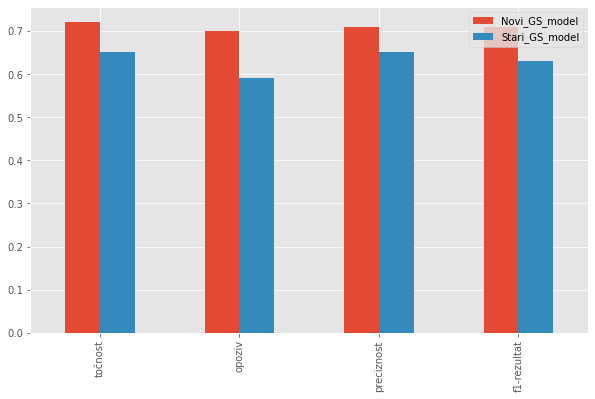

In [31]:
gs_pred_novi_model = gs_model.predict(X_test)
gs_vrijednosti_novi_model = evaluacija(y_test, gs_pred_novi_model)
prikaz_evaluacije(Novi_GS_model=gs_vrijednosti_novi_model, Stari_GS_model=gs_vrijednosti)

Prema ovome je vidljivo kako nova verzija GS modela s uređenom bazom podataka uvelike nadmašuje prijašnju verziju GS modela te postiže točnost veću od 70%. Pošto ovaj model dostiže ciljanu točnost, on će se uzeti kao završna verzija modela.

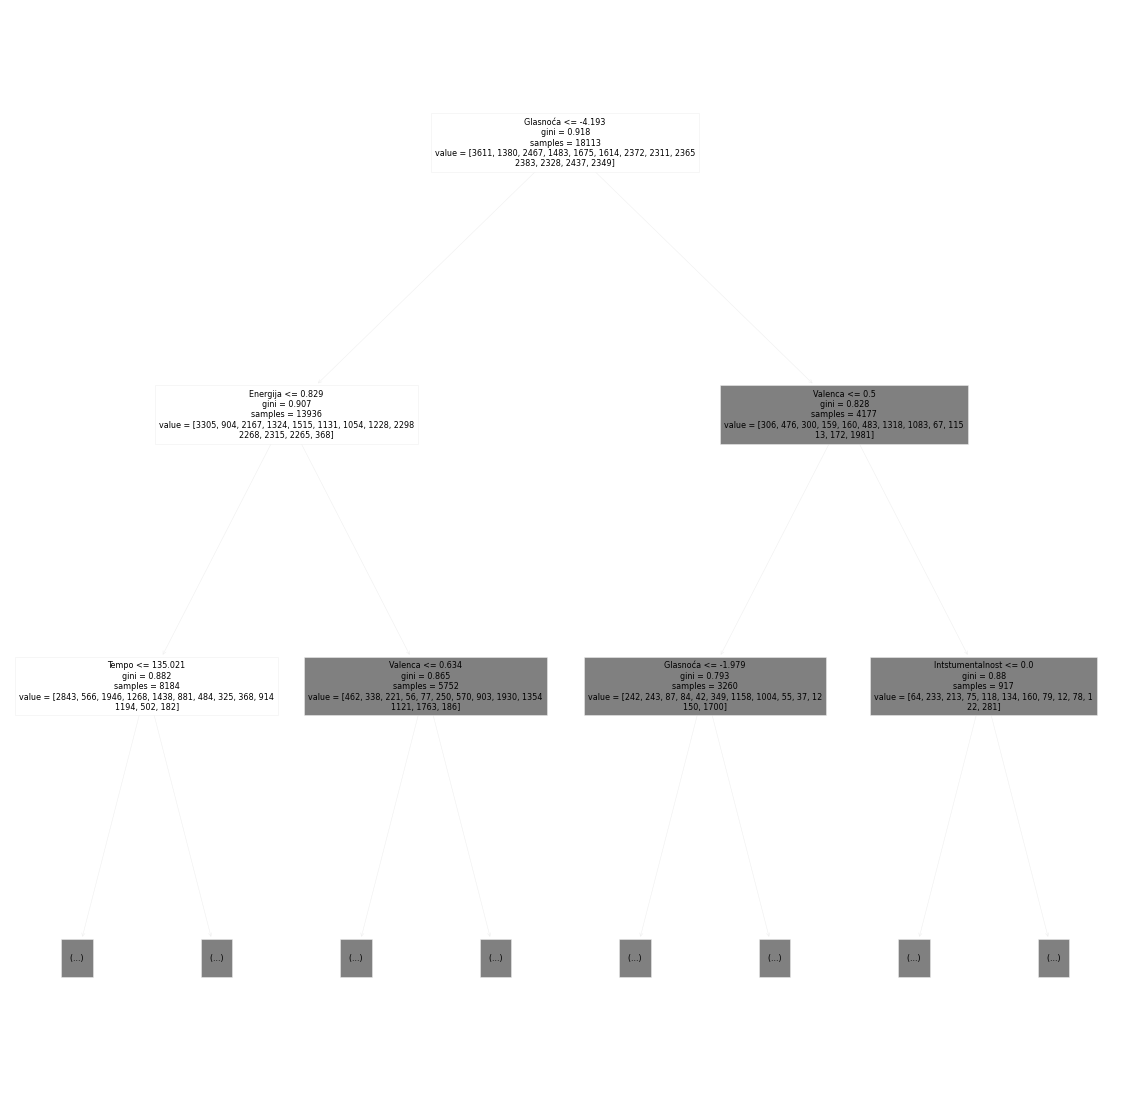

In [32]:
plt.figure(figsize=(20,20))
tree.plot_tree(gs_model.estimators_[0], feature_names=X.columns, max_depth=2, fontsize=8);

Sljedeća slika predstavlja vizualni prikaz prve 3 grane modela naumičnog stabla i njegove funkcije. Stablo nasumično traži zajedničke sličnosti među karakteristikama podataka te ih dijeli na različite grane. Model prati logički slijed kojim prati grane s najvećim brojem uzoraka (koje predstavlja element `samples` na slici). U slučaju druge razine grana model gleda količinu uzoraka koji imaju karaketeristiku `Energija` <= 0.829 i količinu uzoraka koji imaju karakteristiku `Valenca` <= 0.5. Pošto postoji veći broj uzoraka (13936) koji zadovoljavaju prvi uvijet, model prati nastavlja pratiti tu granu stabla. Model nastavlja tim slijedom dok ne dođe do dna stabla gdje će biti žanr u kojega će se pjesma klasificirati unutar ovog određenog stabla. Ovaj proces se ponavlja na svakome stablu odlučivanja te se za završnu klasifikaciju žanra uzima onaj koji je najviše puta bio predviđen kroz sva stabla.

In [33]:
travis = pd.DataFrame([0.4, 0.55, -5, 0.4, 0.22, 0, 0.17, 117], 
                      index=X.columns, columns=[1])

travis.T

,Plesnost,Energija,Glasnoća,Govornost,Akustičnost,Intstumentalnost,Valenca,Tempo
1,0.4,0.55,-5.0,0.4,0.22,0.0,0.17,117.0


In [34]:
trav_pred = gs_model.predict(travis.T)
trav_pred

array(['Hiphop'], dtype=object)